In [1]:
#importing the necessary dependencies. If running this on the SCC, make sure to "module load" 
#necessary dependencies. 

import tensorflow as tf
import numpy as np 
import scipy.io.wavfile as wav 
import argparse 
import time                       
import os
import matplotlib.pyplot as plt
import scipy.signal as signal
import librosa
import scipy


In [2]:
#class to handle audio file loading and preprocessing. generates both 1D and 3D spectrograms
#for specific methods - either multi-layer VGG CNN or shallow random.

class AudioSignal():
    def __init__(self,content,style):
        self.contentFile = content
        self.styleFile = style
        self.N_FFT=2048

    def createSpectrogram(self):
        #method to create spectrogram matrices for both content and style file properties.
        N_FFT = self.N_FFT #fft window size 

        #use Librosa library to load two files.
        yCont, FScont = librosa.load(self.contentFile)
        ySty, FSsty = librosa.load(self.styleFile)

        #perform short time fourier transform
        contS = librosa.stft(yCont,N_FFT)
        styS = librosa.stft(ySty,N_FFT)
        
        #preprocess sound signals 
        p = np.angle(contS)
        contS = np.log1p(np.abs(contS[:,:430])) #truncate sound for consistency
        
        p = np.angle(styS)
        styS = np.log1p(np.abs(styS[:,:430])) #truncate sound for consistency
        
        #get dimensions of content spectrogram as necessary parameters
        self.num_channels = contS.shape[0]
        self.num_samples = contS.shape[1]

        #set sampling rate properties
        self.contentSR = FScont
        self.styleSR = FSsty

        #set 1D matrix parameter for both content and style, truncating style to match content.
        self.contentSpec1D = contS
        self.styleSpec1D = styS[:self.num_channels, :self.num_samples]
        
        #get dimensions of 1D spectrogram to prepare dimensions for 3D
        r,c = self.contentSpec1D.shape
        x = np.zeros(shape=(1,r,c,3))
        y = np.zeros(shape=(1,r,c,3))
        
        #generate 3 dimensional version of spectrogram to prepare for VGG CNN treatment
        for i in range(3):
            x[0,:,:,i] = self.contentSpec1D
            y[0,:,:,i] = self.styleSpec1D
            
        self.contentSpec3D = x
        self.styleSpec3D = y
        
    
    #method to generate initial signal to perform the transfer 
    def initSignal(self,typ):
        if typ == 'content':
            #use content as initial spectrogram
            self.initialSignal = self.contentSpec3D
        if typ == 'random':
            #generate white noise signal
            noise = np.random.uniform(-1.,1., size=self.contentSpec.shape)
            S = librosa.stft(noise,2048)
            p = np.angle(S)
            S = np.log1p(np.abs(S))          

            self.initialSignal = S


In [4]:
#class to perform deep CNN VGG model
class CNN_VGG():
    def __init__(self,audioModel,modelType,outputfilename):
        #audioModel is instantiated AudioModel object holding preprocessed audio parameters
        
        self.weights = 'imagenet-vgg-verydeep-19.mat' #necessary file to get vgg weights
        
        #getting parameters from audio object
        self.inputSpec = audioModel.initialSignal 
        self.audioModel = audioModel

        self.modelType = modelType #type - 5layer, 1pool, shallow
        
        #model loss function weights
        self.alpha = 5e0
        self.beta = 1e4
        self.theta = 1e-3
    
        self.outputfilename = outputfilename
       

    def buildModel5Layer(self):
        #get pre-trained vgg-layer weights
        raw_vgg_net = scipy.io.loadmat(self.weights)
        vgg_layers = raw_vgg_net['layers'][0]
       
        _,h,w,d = self.audioModel.contentSpec3D.shape #shape of 3d representations 
        
        net = {}
        pad = 'VALID'
        net['input'] = tf.Variable(np.zeros((1, h, w, d), dtype=np.float32))

        #here using average pooling using Tensor Flow conv2D method
        
        #layer 1
        net['conv1_1'] = tf.nn.conv2d(net['input'], vgg_layers[0][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[0][0][0][2][0][1]
        net['relu1_1'] = tf.nn.relu(net['conv1_1'] + tf.constant(np.reshape(bias,(bias.size))))
 
        net['conv1_2'] = tf.nn.conv2d(net['relu1_1'], vgg_layers[2][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[2][0][0][2][0][1]
        net['relu1_2'] = tf.nn.relu(net['conv1_2'] + tf.constant(np.reshape(bias,(bias.size))))

        #pool 1
        net['pool1'] = tf.nn.avg_pool(net['relu1_2'], ksize=[1, 2, 2, 1], 
                                      strides=[1, 2, 2, 1], padding=pad)

        
        #layer 2
        net['conv2_1'] = tf.nn.conv2d(net['pool1'], vgg_layers[5][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[5][0][0][2][0][1]
        net['relu2_1'] = tf.nn.relu(net['conv2_1'] + tf.constant(np.reshape(bias,(bias.size))))
 
        net['conv2_2'] = tf.nn.conv2d(net['relu2_1'], vgg_layers[7][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[7][0][0][2][0][1]
        net['relu2_2'] = tf.nn.relu(net['conv2_2'] + tf.constant(np.reshape(bias,(bias.size))))

        #pool 2
        net['pool2'] = tf.nn.avg_pool(net['relu2_2'], ksize=[1, 2, 2, 1], 
                                      strides=[1, 2, 2, 1], padding=pad)

        
        #layer 3
        net['conv3_1'] = tf.nn.conv2d(net['pool2'],vgg_layers[10][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[10][0][0][2][0][1]
        net['relu3_1'] = tf.nn.relu(net['conv3_1'] + tf.constant(np.reshape(bias,(bias.size))))

        net['conv3_2'] = tf.nn.conv2d(net['relu3_1'],vgg_layers[12][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[12][0][0][2][0][1]
        net['relu3_2'] = tf.nn.relu(net['conv3_2'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv3_3'] = tf.nn.conv2d(net['relu3_2'],vgg_layers[14][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[14][0][0][2][0][1]
        net['relu3_3'] = tf.nn.relu(net['conv3_3'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv3_4'] = tf.nn.conv2d(net['relu3_3'],vgg_layers[16][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[16][0][0][2][0][1]
        net['relu3_4'] = tf.nn.relu(net['conv3_4'] + tf.constant(np.reshape(bias,(bias.size))))
        
        #pool 3
        net['pool3'] = tf.nn.avg_pool(net['relu3_4'], ksize=[1, 2, 2, 1], 
                                      strides=[1, 2, 2, 1], padding=pad)

        
        #layer 4
        net['conv4_1'] = tf.nn.conv2d(net['pool3'],vgg_layers[19][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[19][0][0][2][0][1]
        net['relu4_1'] = tf.nn.relu(net['conv4_1'] + tf.constant(np.reshape(bias,(bias.size))))

        net['conv4_2'] = tf.nn.conv2d(net['relu4_1'],vgg_layers[21][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[21][0][0][2][0][1]
        net['relu4_2'] = tf.nn.relu(net['conv4_2'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv4_3'] = tf.nn.conv2d(net['relu4_2'],vgg_layers[23][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[23][0][0][2][0][1]
        net['relu4_3'] = tf.nn.relu(net['conv4_3'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv4_4'] = tf.nn.conv2d(net['relu4_3'],vgg_layers[25][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[25][0][0][2][0][1]
        net['relu4_4'] = tf.nn.relu(net['conv4_4'] + tf.constant(np.reshape(bias,(bias.size))))
        
        #pool 4
        net['pool4'] = tf.nn.avg_pool(net['relu4_4'], ksize=[1, 2, 2, 1], 
                                      strides=[1, 2, 2, 1], padding=pad)


        
        #layer 5
        net['conv5_1'] = tf.nn.conv2d(net['pool4'],vgg_layers[28][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[28][0][0][2][0][1]
        net['relu5_1'] = tf.nn.relu(net['conv5_1'] + tf.constant(np.reshape(bias,(bias.size))))

        net['conv5_2'] = tf.nn.conv2d(net['relu5_1'],vgg_layers[30][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[30][0][0][2][0][1]
        net['relu5_2'] = tf.nn.relu(net['conv5_2'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv5_3'] = tf.nn.conv2d(net['relu5_2'],vgg_layers[32][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[32][0][0][2][0][1]
        net['relu5_3'] = tf.nn.relu(net['conv5_3'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv5_4'] = tf.nn.conv2d(net['relu5_3'],vgg_layers[34][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[34][0][0][2][0][1]
        net['relu5_4'] = tf.nn.relu(net['conv5_4'] + tf.constant(np.reshape(bias,(bias.size))))
        
        #pool 5
        net['pool5'] = tf.nn.avg_pool(net['relu5_4'], ksize=[1, 2, 2, 1], 
                                      strides=[1, 2, 2, 1], padding=pad)

        self.net = net #assign property that is the built CNN model
        
    
    
    def buildModelShallowLayer(self):
        #get pre-trained vgg-layer weights
        raw_vgg_net = scipy.io.loadmat(self.weights)
        vgg_layers = raw_vgg_net['layers'][0]
       
        _,h,w,d = self.audioModel.contentSpec3D.shape
        
        net = {}
        pad = 'VALID'
        net['input'] = tf.Variable(np.zeros((1, h, w, d), dtype=np.float32))

        #shallow 1
        net['conv1_1'] = tf.nn.conv2d(net['input'], vgg_layers[0][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[0][0][0][2][0][1]
        net['relu1_1'] = tf.nn.relu(net['conv1_1'] + tf.constant(np.reshape(bias,(bias.size))))


        self.net = net
        
    
    def buildModel1PoolLayer(self):
        #get pre-trained vgg-layer weights
        raw_vgg_net = scipy.io.loadmat(self.weights)
        vgg_layers = raw_vgg_net['layers'][0]
       
        _,h,w,d = self.audioModel.contentSpec3D.shape
        
        net = {}
        pad = 'VALID'
        net['input'] = tf.Variable(np.zeros((1, h, w, d), dtype=np.float32))

        #here using average pooling
        #layer 1
        net['conv1_1'] = tf.nn.conv2d(net['input'], vgg_layers[0][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[0][0][0][2][0][1]
        net['relu1_1'] = tf.nn.relu(net['conv1_1'] + tf.constant(np.reshape(bias,(bias.size))))
 
        net['conv1_2'] = tf.nn.conv2d(net['relu1_1'], vgg_layers[2][0][0][2][0][0], 
                                      strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[2][0][0][2][0][1]
        net['relu1_2'] = tf.nn.relu(net['conv1_2'] + tf.constant(np.reshape(bias,(bias.size))))

        #pool 1
        net['pool1'] = tf.nn.avg_pool(net['relu1_2'], ksize=[1, 2, 2, 1], 
                                      strides=[1, 2, 2, 1], padding=pad)
        self.net = net
    
        
    def content_layer_loss(self,p, x):
        #calculate loss of the CNN content layer
        _, h, w, d = p.get_shape()
        M = h.value * w.value
        N = d.value
        
        K = 1. / (2. * N**0.5 * M**0.5) #loss function 
        #K = 1. / (N * M)
        #K = 1. / 2.
        loss = K * tf.reduce_sum(tf.pow((x - p), 2)) #tf reduce_sum method
        return loss

    def style_layer_loss(self,a, x):
        #calculate loss of CNN style layer
        _, h, w, d = a.get_shape()
        M = h.value * w.value
        N = d.value
        A = self.gram_matrix(a, M, N) #generate gram matrices
        G = self.gram_matrix(x, M, N)
        loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2)) #calculate loss
        return loss

    def gram_matrix(self,x, area, depth):
        #method to generate gram matrices for style layer
        
        F = tf.reshape(x, (area, depth))
        G = tf.matmul(tf.transpose(F), F)
        return G


    def styleLoss(self,sess):
        #generate loss of style layers 
        
        styleSpec = self.audioModel.styleSpec3D
        net = self.net
        
        sess.run(net['input'].assign(styleSpec))
        styleloss = 0.
        
        #generate the weights per style layers according to method used
        if self.modelType == 'shallow':
            styleLayersVGG = ['relu1_1']
            styleLayerWeights = [1.]
        if self.modelType == '1layerpool':
            styleLayersVGG = ['relu1_1']
            styleLayerWeights = [1.]
        if self.modelType == '5layerpool':
            styleLayersVGG = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
            styleLayerWeights = [0.2, 0.2, 0.2, 0.2, 0.2] #equal weighting to all 5
            
        #for each layer, calculate the loss of layer and calculate net weighted loss per layer
        for layer, weight in zip(styleLayersVGG, styleLayerWeights):
            a = sess.run(net[layer])
            x = net[layer]
            a = tf.convert_to_tensor(a)
            styleloss += self.style_layer_loss(a, x) * weight

        #takae the average and return 
        styleloss /= float(len(styleLayersVGG))
        return styleloss

    
    def contentLoss(self,sess):
        contentSpec = self.audioModel.contentSpec3D
        net = self.net
        sess.run(net['input'].assign(contentSpec))     
        
        #content layer used according to paper method (Gatys et Al.)
        if self.modelType == 'shallow':
            contentLayer = 'conv1_1'
        if self.modelType == '1layerpool':
            contentLayer = 'conv1_1'
        if self.modelType == '5layerpool':
            contentLayer = 'conv4_2' #for 5 layer use conv4_2
        
        #calculate content loss of specified layer
        p = sess.run(net[contentLayer])
        x = net[contentLayer]
        p = tf.convert_to_tensor(p)
        content_loss = self.content_layer_loss(p, x)
        
        return content_loss

    def minimizeLBGFS(self,sess,optimizer):
        # function for optimizing and minimizing loss. Used LBGFS optimization 
        
        initSpec = self.audioModel.initialSignal

        initOp = tf.global_variables_initializer()
        sess.run(initOp)
        sess.run(self.net['input'].assign(initSpec))
        optimizer.minimize(sess)

    def convertOutput(self,result):
        #method to take produced TF result and perform inverse fft to produce audio output
        
        N_FFT=2048
                
        #using 3 dimensional representation. must take average over the z layer for output
        #spectrogram
        flattenresult = np.mean(result[0],axis=2)
                
        a = np.zeros_like(flattenresult)
        a[:self.audioModel.num_channels,:] = np.exp(flattenresult[0,0].T) - 1

        # This code is supposed to do phase reconstruction
        p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
        for i in range(500):
            S = a * np.exp(1j*p)
            x = librosa.istft(S)
            p = np.angle(librosa.stft(x, N_FFT))
            
        #write result with specified file name    
        librosa.output.write_wav(self.outputfilename, x, self.audioModel.contentSR)


    def run(self):
        graph = tf.Graph()

        #open tensor flow with gpu
        with tf.Graph().as_default(), tf.device('/gpu:0'), tf.Session() as sess:
            
            #build model according to type specified
            if self.modelType == 'shallow':
                self.buildModelShallowLayer()
                
            if self.modelType == '1layerpool':
                self.buildModel1PoolLayer()

            if self.modelType == '5layerpool':
                self.buildModel5Layer()
                
            #self.net is the network
            LossStyle = self.styleLoss(sess)
            LossContent = self.contentLoss(sess)

            L_tv = tf.image.total_variation(self.net['input'])

            #generate weighted loss total
            LossTotal  = self.alpha * LossContent
            LossTotal += self.beta  * LossStyle
            LossTotal += self.theta * L_tv

            #optimizer = lgbfs

            maxIterations = 1000
            optimizerLBFGS = tf.contrib.opt.ScipyOptimizerInterface(
                LossTotal, method='L-BFGS-B',
                options={'maxiter': maxIterations,
                         'disp': 0})

            self.minimizeLBGFS(sess,optimizerLBFGS)

            outputSpec = sess.run(self.net['input'])
            outputSignal = self.convertOutput(outputSpec)


            

In [6]:
#class to build shallow untrained CNN model
class CNN_Shallow():

    def __init__(self,audioModel,outputfilename):
        #instantiate parameters for CNN model
        self.audioModel = audioModel
        self.alpha = 1e-2 #content weight
        self.beta = 1 #style weight
        self.outputfilename = outputfilename
        self.numfilters = 4096
        
        
    def gram_matrix(self,x, area, depth, typeGram):
        #method to generate style gram matrix
        if typeGram == 'np':
            F = np.reshape(x, (area, depth))
            G = np.matmul(F.T, F)
        if typeGram == 'tf':
            F = tf.reshape(x,(area,depth))
            G = tf.matmul(tf.transpose(F), F)
        return G/self.audioModel.num_samples
    
    def runModel(self):
        audioModel = self.audioModel
        
        content = audioModel.contentSpec1D
        style = audioModel.styleSpec1D
        
        #need to force spectrograms to be in contiguous memory for TF use
        contentTf = np.ascontiguousarray(content.T[None,None,:,:])
        styleTf = np.ascontiguousarray(style.T[None,None,:,:])
        
        #calculate std and generate a random kernel based on std for intitial calculations
        std = np.sqrt(2) * np.sqrt(2.0 / ((audioModel.num_channels + self.numfilters) * 11))
        kernel = np.random.randn(1, 11, audioModel.num_channels, self.numfilters)*std
        
        
        #first stage of algorithm to calculate the content and style features
        
        #open tensorflow graph with gpu
        g = tf.Graph()
        with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
            
            #placeholder variable with correct dimensions and kernel  for tensor flow
            x = tf.placeholder('float32', [1,1,audioModel.num_samples,audioModel.num_channels], name="x")        
            kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
            
            #generate the single shallow CNN with one convolutional and ReLu layer
            conv = tf.nn.conv2d(x,kernel_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv")
            net = tf.nn.relu(conv)
        
            #generate style gram and content features
            contentFeatures = net.eval(feed_dict={x: contentTf})
            styleFeatures = net.eval(feed_dict={x: styleTf})            
            styleGram = self.gram_matrix(styleFeatures,-1,self.numfilters,'np')

            
        #second stage of algorithm to backpropogate and optimize loss function
        with tf.Graph().as_default():   
            
            #use tf Variable with random Variable. create kernel
            x = tf.Variable(np.random.randn(1,1,audioModel.num_samples,
                                            audioModel.num_channels).astype(np.float32)*1e-3, name="x")
            kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
            
            #create shallow CNN 
            conv = tf.nn.conv2d(x,kernel_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv")
            net = tf.nn.relu(conv)
        
            #calculate content loss with calculated content features
            contentLoss = tf.nn.l2_loss( net - contentFeatures)
    
            #calculate style loss with style gram
            shape = net.get_shape().as_list()[3]
            gram = self.gram_matrix(net,-1,shape,'tf')
            styleLoss = tf.nn.l2_loss(gram - styleGram)
            
            #generate weighted total loss according to weight parameters 
            totalLoss = (self.alpha*contentLoss) + (self.beta*styleLoss) 
            
            #create L-BFGS-B optimizer
            optimizer = tf.contrib.opt.ScipyOptimizerInterface(totalLoss, method='L-BFGS-B', 
                                                               options={'maxiter': 300})
            
            #optimize TF session
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
       
                print('Started optimization.')
                optimizer.minimize(sess)

                result = sess.run(x)
    
            #save result of optimization to property
            self.result = result
            
    def postprocess(self):
        #method to take produced TF result and perform inverse fft to produce audio output
        N_FFT = 2048 #fft window size
        
        audioModel = self.audioModel
        content = audioModel.contentSpec1D
        
        a = np.zeros_like(content)
        a[:audioModel.num_channels,:] = np.exp(self.result[0,0].T) - 1

        #perform phase reconstruction
        p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
        for i in range(500):
            S = a * np.exp(1j*p)
            x = librosa.istft(S)
            p = np.angle(librosa.stft(x, N_FFT))
    
        #write wav file with post-processed result
        librosa.output.write_wav(self.outputfilename, x, audioModel.styleSR)
        
    def run(self):
        self.runModel()
        self.postprocess()
        
                  

In [10]:
def runNetwork(method):

    contentfile = 'audio_input/malevoice.mp3'
    stylefile = 'audio_input/mandarinfemalevoice.mp3'
    
    audioModel = AudioSignal(contentfile,stylefile)
    audioModel.createSpectrogram()
    
    if method == 'VGG':
        audioModel.initSignal('content')
        #outputfileVGG = "audio_output/result_female-male-VGG5.wav"
        outputfileVGG = "audio_output/resultVGG-shallow.wav"
        CNNVGG_model = CNN_VGG(audioModel,'shallow',outputfileVGG)
        CNNVGG_model.run()
    
    if method == 'shallow':
        outputFileShallow = "audio_output/result_female-male-shallow.wav"
        CNNShallow_model = CNN_Shallow(audioModel,outputFileShallow)
        CNNShallow_model.run()


In [ ]:
#run the network based on the method input
method ='shallow'
audioModel = runNetwork(method)

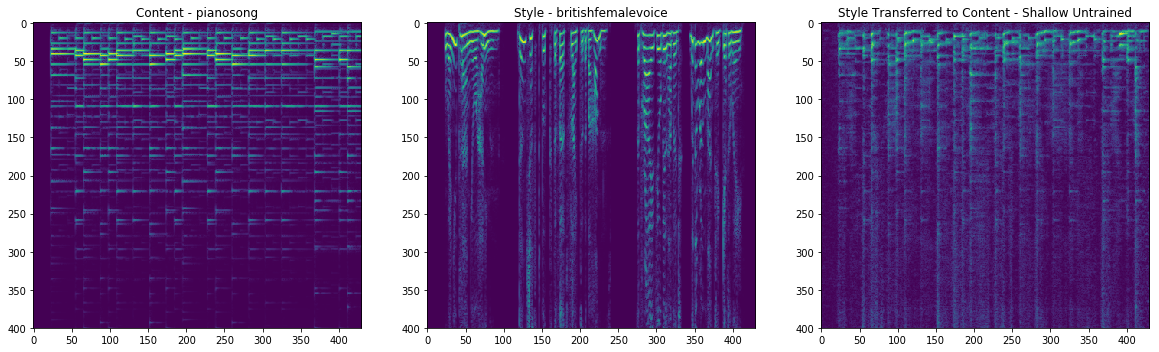

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

#methods to display results

def readSpectrum(filename):
    #read audio signal and process for spectrogram using librsoa
    N_FFT = 2048
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))   #truncate sound
    return S, fs


def displayResults(content,style,synth):
    
    contentS, _ = readSpectrum(content)
    styleS, _ = readSpectrum(style)
    synthS, _ = readSpectrum(synth)
    
    nsamples = contentS.shape[1]
    nchannels = contentS.shape[0]
    styleS = styleS[:nchannels, :nsamples]
    
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    tit = content.split('/')[1].split('.')[0]
    plt.title('Content - '+tit)
    plt.imshow(contentS[:400,:])
    plt.subplot(1, 3, 2)
    tit = style.split('/')[1].split('.')[0]

    plt.title('Style - '+tit)
    plt.imshow(styleS[:400,:])
    
    plt.subplot(1, 3, 3)
    
    #place proper method here for disp
    plt.title('Style Transferred to Content - Shallow Untrained') 
    plt.imshow(synthS[:400,:])
    plt.show()

    
displayResults('audio_input/pianosong.mp3',
               'audio_input/britishfemalevoice.mp3',
               'audio_output/result_female-piano-2.wav')
    

In [15]:
#display various sound files

from IPython.display import Audio, display
display(Audio('audio_output/result_female-male-3.wav'))
display(Audio('audio_input/malevoice.mp3'))
display(Audio('audio_input/mandarinfemalevoice.mp3'))
display(Audio('audio_output/result_piano-female-2.wav'))
display(Audio('audio_output/result_cricket-male-2.wav'))
display(Audio('audio_output/result_cricket-male-2.wav'))
display(Audio('audio_input/crickets.mp3'))